# Turbomachinery Student Project – Pump Analysis 74360

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 1. Load measured flow data

In [27]:
# Reads the CSV file containing one measurement per minute over 24 hours.
# Expected columns: Timestamp and Volume Flow [m³/h]
flow_data = pd.read_csv("volume_flow_data.csv")
flow_data.columns = ["Timestamp", "Volume Flow (m^3/h)"]
flow_data["Timestamp"] = pd.to_datetime(flow_data["Timestamp"])

# 2. Define reference values from pump hydraulic performance curves

In [28]:
# These values describe how head, efficiency, and power vary with flow rate.
# They are taken from the pump manufacturer's datasheet.
Q_reference = np.array([0, 100, 200, 300, 400, 500, 580])                   # Volume flow rate [m³/h]
eta_reference = np.array([0.0, 0.40, 0.65, 0.799, 0.85, 0.85, 0.80])        # Hydraulic efficiency (as fraction, not percent)
head_reference = np.array([23.5, 23.0, 22.5, 21.0, 18.5, 16.0, 13.5])       # Hydraulic head [m]

# 3. Create interpolation functions for continuous evaluation

In [29]:
# These allow calculating head and efficiency for any flow value
# between the given support points using linear interpolation.
get_eta = interp1d(Q_reference, eta_reference, kind="linear")
get_head = interp1d(Q_reference, head_reference, kind="linear")

# 4. Define physical constants

In [30]:
# Used to calculate hydraulic power from flow and head.
rho = 969   # Density of water [kg/m³] at approx. 40°C
g = 9.81    # Gravitational acceleration [m/s²]

# 5. Interpolate hydraulic head and efficiency for each measured flow

In [31]:
# Applies the interpolation functions to the flow rate column.
flow_data["Efficiency"] = get_eta(flow_data["Volume Flow (m^3/h)"])
flow_data["Head (m)"] = get_head(flow_data["Volume Flow (m^3/h)"])

# Convert flow rate from m³/h to m³/s to match SI units for power
flow_data["Flow (m^3/s)"] = flow_data["Volume Flow (m^3/h)"] / 3600

# 6. Calculate hydraulic and electrical power

In [32]:
# Hydraulic power: P_hyd = ρ * g * Q * H / 1000 → [kW]
# Electrical input power: P_el = P_hyd / η
flow_data["P_hyd (kW)"] = (rho * g * flow_data["Flow (m^3/s)"] * flow_data["Head (m)"]) / 1000
flow_data["P_el (kW)"] = flow_data["P_hyd (kW)"] / flow_data["Efficiency"]

# 7. Calculate electrical energy per minute and cumulative energy

In [33]:
# Energy = Power × Time, with time step = 1 min = 1/60 h
flow_data["E_el (kWh)"] = flow_data["P_el (kW)"] * (1 / 60)
flow_data["E_el_cum (kWh)"] = flow_data["E_el (kWh)"].cumsum()

# 8. Compute hydraulic energy and energy losses

In [34]:
# Hydraulic energy = P_hyd * Δt, same time step
# Loss = E_el - E_hyd
# Cumulative loss is tracked for visualization
flow_data["E_hyd (kWh)"] = flow_data["P_hyd (kW)"] * (1 / 60)
flow_data["E_loss (kWh)"] = flow_data["E_el (kWh)"] - flow_data["E_hyd (kWh)"]
flow_data["E_loss_cum (kWh)"] = flow_data["E_loss (kWh)"].cumsum()



# 9. Calculate totals and average efficiency over 24 hours


In [35]:
# These values summarize energy use and system performance.
total_energy = flow_data["E_el (kWh)"].sum()                        # Total input energy
total_P_hyd = flow_data["P_hyd (kW)"].sum()                         # For average η calculation
total_P_el = flow_data["P_el (kW)"].sum()
average_eta_hydraulic = total_P_hyd / total_P_el                    # Average hydraulic efficiency
total_E_hyd = flow_data["E_hyd (kWh)"].sum()                        # Total useful energy
total_E_loss = flow_data["E_loss (kWh)"].sum()                      # Total wasted energy


# 10. Print results


In [36]:
print(f"Total electrical energy consumption over 24 hours:  {total_energy:.2f} kWh")
print(f"Average hydraulic efficiency over 24 hours:           {average_eta_hydraulic:.2%}")
print(f"Total non-hydraulic (lost) energy over 24 hours:     {total_E_loss:.2f} kWh")

Total electrical energy consumption over 24 hours:  472.43 kWh
Average hydraulic efficiency over 24 hours:           71.05%
Total non-hydraulic (lost) energy over 24 hours:     136.77 kWh



# 11. Plot: Electrical Input Power Over 24 Hours


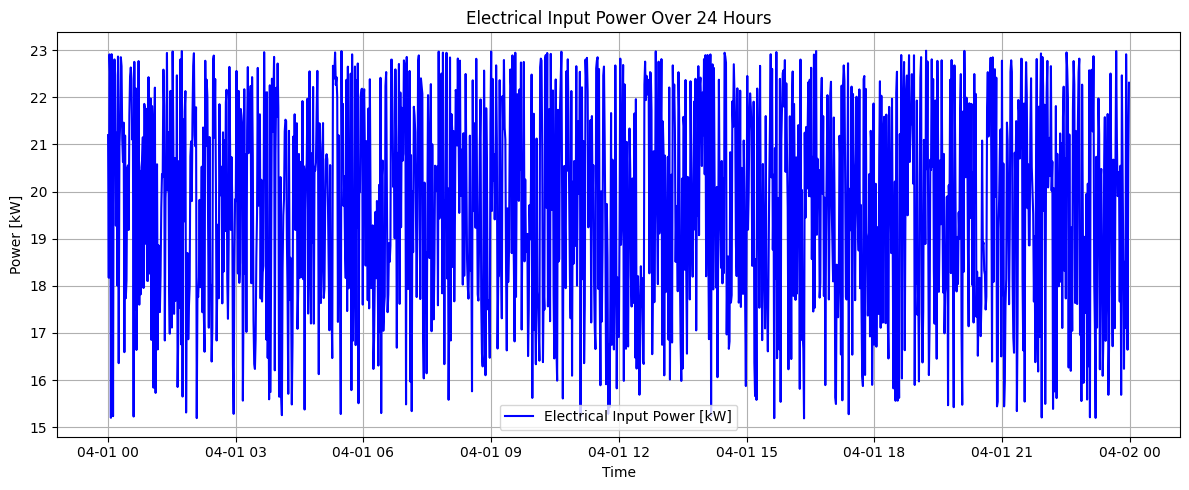

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(flow_data["Timestamp"], flow_data["P_el (kW)"], label="Electrical Input Power [kW]", color="blue")
plt.xlabel("Time")
plt.ylabel("Power [kW]")
plt.title("Electrical Input Power Over 24 Hours")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 12. Plot: Cumulative Electrical Energy Consumption Over 24 Hours


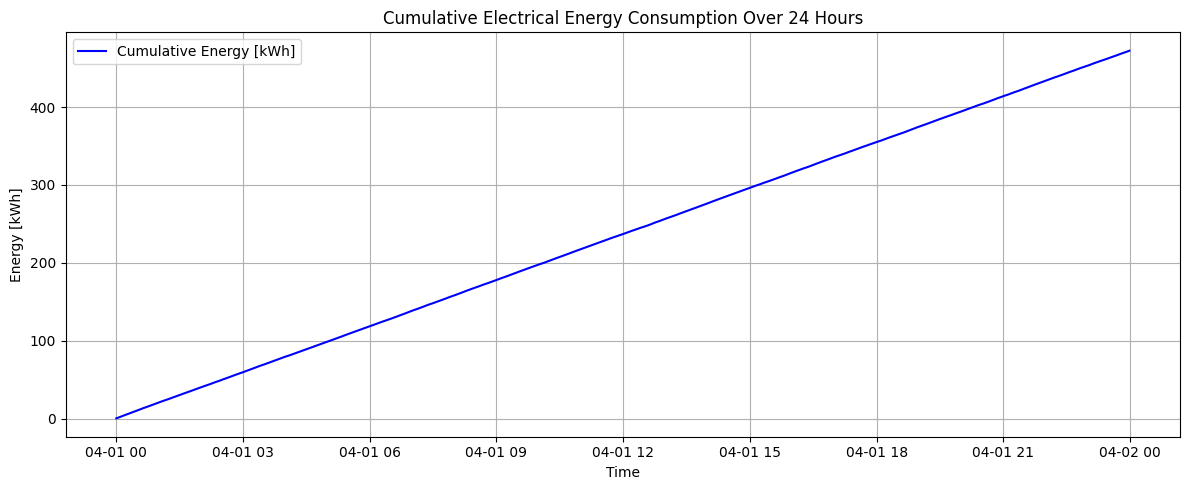

In [38]:
plt.figure(figsize=(12, 5))
plt.plot(flow_data["Timestamp"], flow_data["E_el_cum (kWh)"], label="Cumulative Energy [kWh]", color="blue")
plt.xlabel("Time")
plt.ylabel("Energy [kWh]")
plt.title("Cumulative Electrical Energy Consumption Over 24 Hours")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 13. Plot: Hydraulic Efficency Over 24 Hours


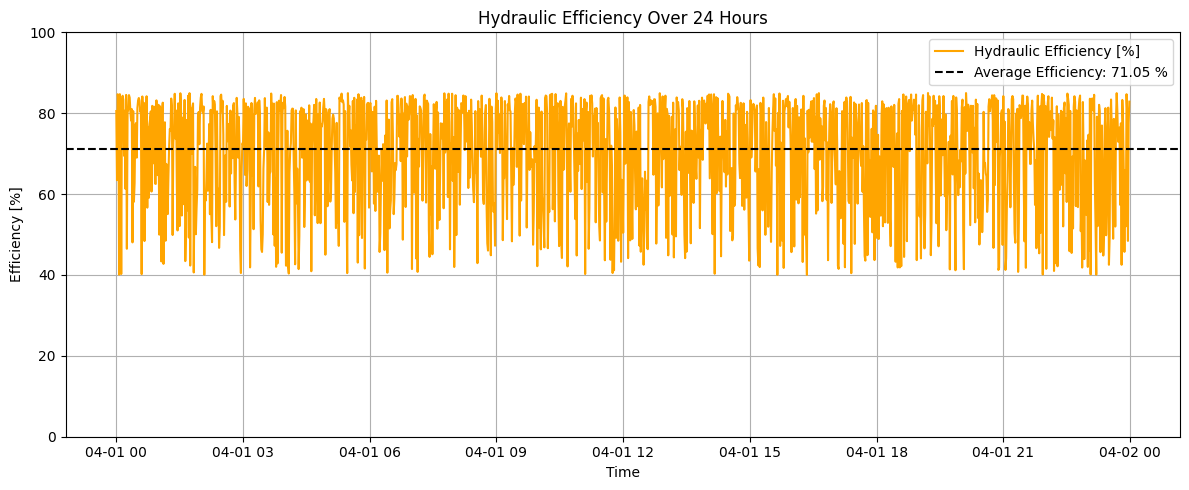

In [39]:
average_eta_hydraulic_percent = average_eta_hydraulic * 100

plt.figure(figsize=(12, 5))
plt.plot(flow_data["Timestamp"], flow_data["Efficiency"] * 100,
         label="Hydraulic Efficiency [%]", color="orange")
plt.axhline(y=average_eta_hydraulic_percent, color="black", linestyle="--",
            label=f"Average Efficiency: {average_eta_hydraulic_percent:.2f} %")
plt.xlabel("Time")
plt.ylabel("Efficiency [%]")
plt.title("Hydraulic Efficiency Over 24 Hours")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 14. Plot: Cumulative Non-Hydraulic Energy Loss Over 24 Hours


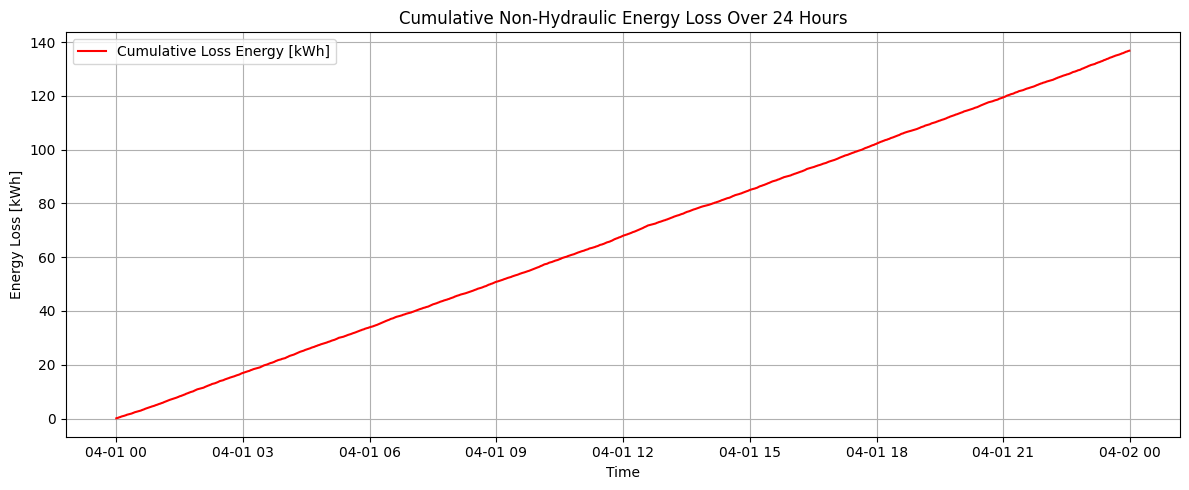

In [40]:
plt.figure(figsize=(12, 5))
plt.plot(flow_data["Timestamp"], flow_data["E_loss_cum (kWh)"],
         label="Cumulative Loss Energy [kWh]", color="red")
plt.xlabel("Time")
plt.ylabel("Energy Loss [kWh]")
plt.title("Cumulative Non-Hydraulic Energy Loss Over 24 Hours")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 15. Plot: Non-Hydraulic Energy Loss Over 24 Hours

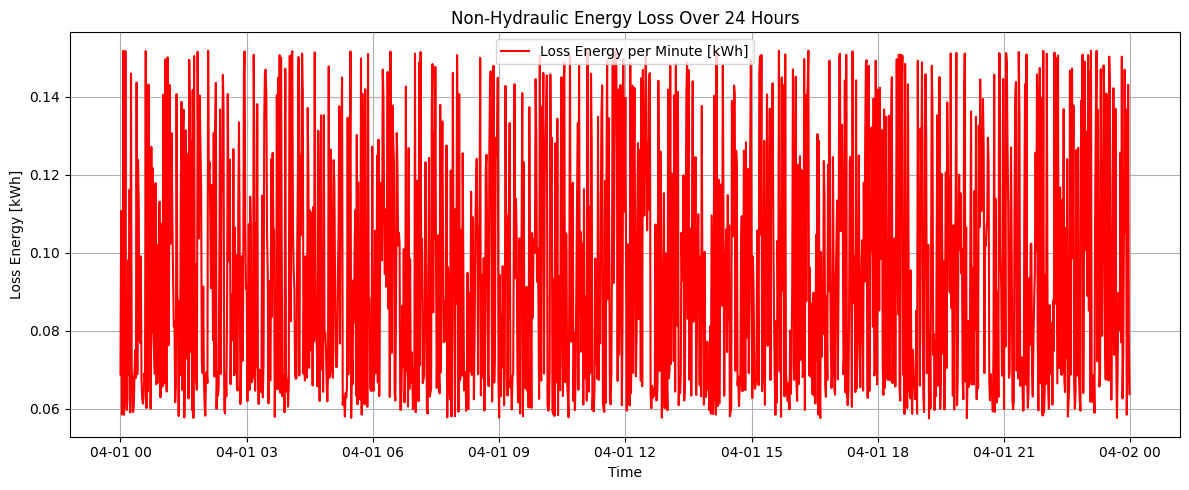

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(flow_data["Timestamp"], flow_data["E_loss (kWh)"],
         label="Loss Energy per Minute [kWh]", color="red")
plt.xlabel("Time")
plt.ylabel("Loss Energy [kWh]")
plt.title("Non-Hydraulic Energy Loss Over 24 Hours")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()